In [30]:
import re
import requests
from bs4 import BeautifulSoup
from copy import deepcopy
from time import sleep
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex


def getUpdate():
    return requests.get('https://static01.nyt.com/elections-assets/2020/data/api/2020-11-03/votes-remaining-page/national/president.json').json()


def parseUpdate(toParse):
    parsed = {}
    for state in toParse["data"]["races"]:
        parsed[state["state_name"]] = {
            "name": state["state_name"],
            # "lastUpdate": state["last_updated"],
            "votes": state["votes"],
            "votePercent": state["eevp"],
            "candidates": {}
        }

        for candidate in state["candidates"]:
            if 'Trump' in candidate['last_name'] or 'Biden' in candidate['last_name']:
                parsed[state["state_name"]]["candidates"][candidate["last_name"]] = {
                    "name": candidate["last_name"],
                    "votes": candidate["votes"],
                    # "percent": candidate["percent"]
        }

    return parsed

In [63]:
data_dict = parseUpdate(getUpdate())
simple_dict = {}

for state in data_dict.keys():
    simple_dict[state] = {
        'Biden': data_dict[state]['candidates']['Biden']['votes'],
        'Trump': data_dict[state]['candidates']['Trump']['votes']
    }

In [98]:
drop_cols = ['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'LSAD', 'ALAND', 'AWATER']

election_df = pd.DataFrame(simple_dict).T
election_df['NAME'] = election_df.index
states = gpd.read_file('data/usa-states-census-2014.shp')
states = states.drop_duplicates()
election_df = states.merge(election_df, on='NAME')
election_df = election_df.drop(drop_cols, axis=1)
election_df['Vote Total'] = election_df['Biden'] + election_df['Trump']
election_df['Relative Vote Total'] = np.log(election_df['Vote Total'])/np.log(max(election_df['Vote Total']))
election_df['Pct Biden'] = election_df['Biden']/election_df['Vote Total']
election_df['Pct Trump'] = election_df['Trump']/election_df['Vote Total']
election_df.columns = ['State Code', 'State Name', 'Region', 'geometry', 'Biden', 'Trump', 'Vote Total', 'Relative Vote Total',
       'Pct Biden', 'Pct Trump']

In [170]:
election_df['b'] = election_df.apply(lambda x: x['Pct Biden'], axis=1)
election_df['r'] = election_df.apply(lambda x: x['Pct Trump'], axis=1)
election_df['g'] = election_df.apply(lambda x: min(x['b'], x['r']), axis=1)
election_df['rgb'] = election_df.apply(lambda x: (x['r'], x['g'], x['b']), axis=1)
election_df['rgb'] = election_df.apply(lambda x: (x['r'], x['g'], x['b'], x['Relative Vote Total']), axis=1)
# election_df['rgb'] = election_df.apply(lambda x: tuple((x['Relative Vote Total'])*val for val in x['rgb']), axis=1)
# election_df['rgb'] = election_df.apply(lambda x: to_hex(x['rgb']), axis=1)
# election_df['rgb'] = election_df.apply(lambda x: to_hex(x['rgb'], keep_alpha=True), axis=1)

In [171]:
# for col1, col2 in zip(election_df['rgb'], election_df.apply(lambda x: tuple((1-x['Relative Vote Total'])*val for val in x['rgb']), axis=1)):
#     print(col1[0], col2[0])

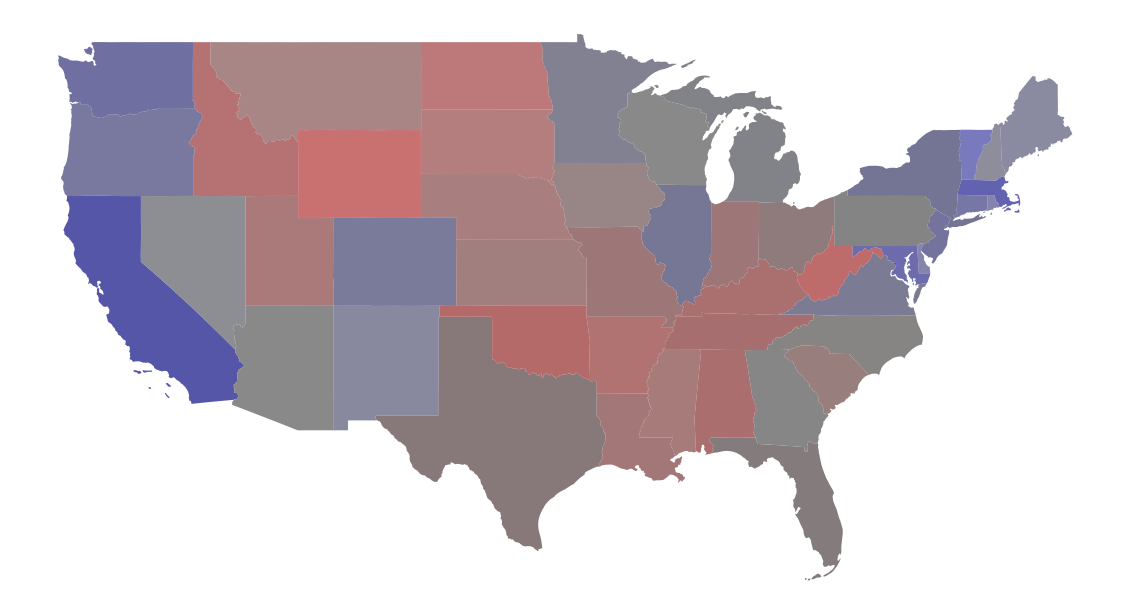

In [175]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.axis('off')
ax.set_aspect('equal')
# cm = mcol.LinearSegmentedColormap.from_list("BuRd",["r", 'w', "b"])
election_df.plot(color=election_df['rgb'], facecolor="none", ax=ax); # edgecolor="black", cmap=cm